# Exercises

In [17]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import math
from sklearn.model_selection import StratifiedKFold
from ipywidgets import interactive
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, a the best value of the $C$ hyperparameter for this dataset?

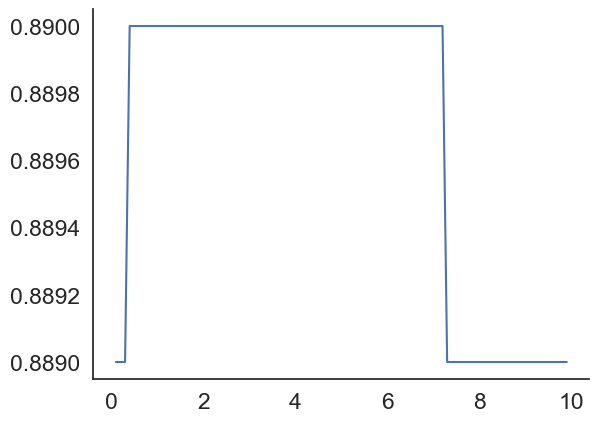

In [39]:
X, y = make_blobs(n_samples=1000,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.8)

Cs = np.arange(0.1, 10, 0.1)
performances = []

for C in Cs:
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X, y)
    performances.append(clf.score(X, y))

plt.plot(Cs, performances)

Without using (cross-validation), the performance seems to be around 0.9 for all values for C from 0.1 to 10, in steps of 0.1. When rerunning the code above, a different value for C seems to be the optimal on every run. This is probably due to the validation performance being obtained by using the training data, which makes it unreliable.

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)). 
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


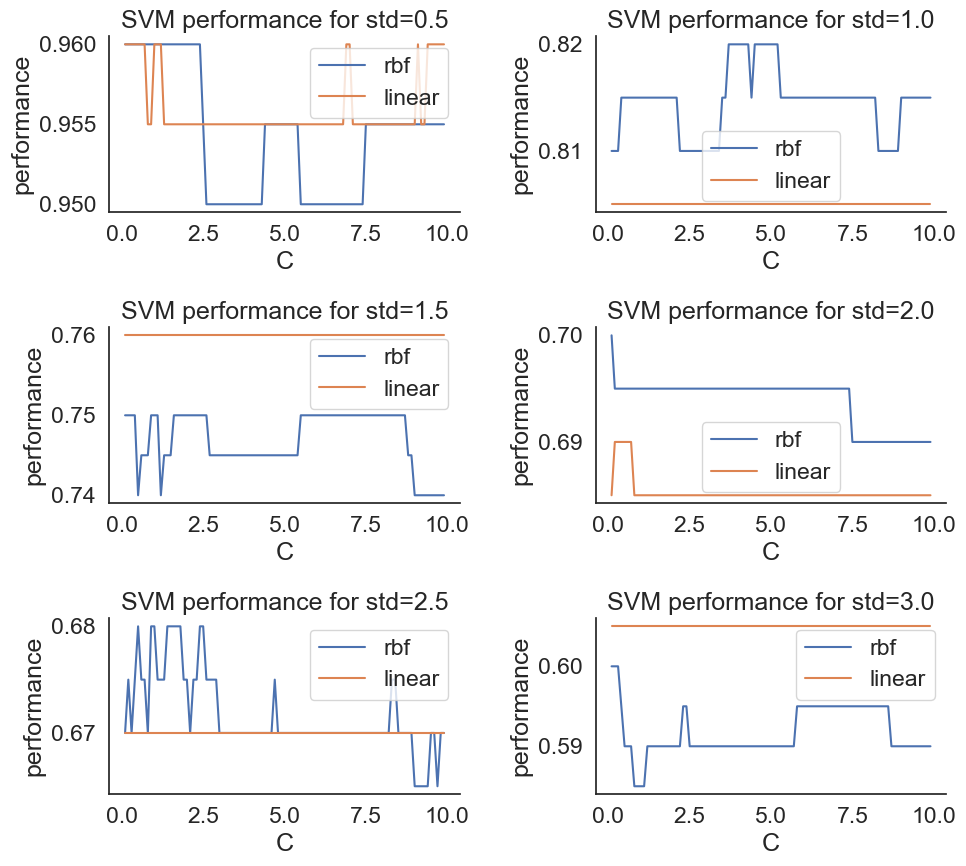

In [45]:
N = 1000
train_N = int(N * .8)
stds = np.arange(.5, 3.5, 0.5)

kernels = ['rbf', 'linear']
Cs = np.arange(0.1, 10, 0.1)

n_cols = 2
n_rows = math.ceil(len(stds) / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))

for i, std in enumerate(stds):
    X, y = make_blobs(n_samples=N,n_features=2,centers=[[-1,0],[1,0]],cluster_std=std)
    X_train, y_train, X_test, y_test = X[:train_N], y[:train_N], X[train_N:], y[train_N:]

    for kernel in kernels:
        performances = []

        for C in Cs:
            clf = svm.SVC(kernel=kernel, C=C)
            clf.fit(X_train, y_train)
            performances.append(clf.score(X_test, y_test))

        ax = axs[i // n_cols, i % n_cols]
        ax.plot(Cs, performances, label=kernel)
        ax.legend()
        ax.set_title(f'SVM performance for std={std}')
        ax.set_xlabel('C')
        ax.set_ylabel('performance')

fig.tight_layout()

As expected, the performance for both linear and rbf kernels descreases as the generated data becomes increasingly non-linear (i.e., the std increases). As in the last exercise it is not clear what value for C is optimal, as the performance varies greatly between runs and different values for std. In the last exercise I mentioned this was likely due to not using separate validation data, but now we are using validation data this effect still persists. It is also not clear which of the kernel types (linear or rbf) is superior for this data, since it depends on the std and also the value for C which kernel type leads to a higher performance.

### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

In [23]:
def generate_data(sigma_stim = 0.5, n_cells = 20, average_firing_rate = 5):
    n_stim_type = 2; # number of different stimuli

    # generate baseline rates from exponential distirbution
    cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

    # create stimulus average responses, perturbing the population firng rate profile
    # we use a multiplicative modulation in opposite directions for the two stimuli
    modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
    cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
    # sets negative firng rate to 0
    cell_rate_stim[1][cell_rate_stim[1]<0]=0
    cell_rate_stim[2][cell_rate_stim[2]<0]=0

    # simulate spiking activity

    s_rate = 10000 # the sampling rate of our emulated recording system
    noise_rate = 1 # we are going to add some spike noise non related to the task
    n_stim = 100 # number of stimuli

    stim_dur = 2 #stimulus duration (in seconds)
    is_interval = 3 # interval between stimuli  (in seconds)

    stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
    stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
    np.random.shuffle(stim_type)

    time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

    spike_times = []
    for cell in range(n_cells):
        spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
        for i,stimulus in enumerate(stim_type):
            stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
            spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

        spike_times.append(time[spikes>0])

    return spike_times, stim_onsets, stim_type, stim_dur

def decode_data(spike_times, stim_onsets, stim_type, stim_duration):
    onset = 1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(-onset,stim_duration+offset+binwidth,binwidth)

    n_cells = len(spike_times)
    n_trials= len(stim_type)

    X = np.zeros((n_cells,n_trials,len(bins)-1));
    for cell in range(n_cells):    
        for trial in range(n_trials):

            # selects spikes that are in trial
            sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                    spike_times[cell]<stim_onsets[trial]+stim_duration+offset)
            
            # centers spike times around stimulus onset
            sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
            #bins spikes
            spike_count,_ = np.histogram(sp_cntr,bins)
            #spike_count = zscore(spike_count)
            X[cell,trial,:] = spike_count

    n_splits = 5

    avg_performance = []
    std_performance = []

    for time_bin in range(X.shape[-1]):
            # setting 2-fold cross validation
            kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
            fold_performance = []

            for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):
                    

                    X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                    y_train, y_test = stim_type[train_index], stim_type[test_index]

                    clf = svm.LinearSVC(max_iter=1000)
                    clf.fit(X_train, y_train)
                    fold_performance.append(clf.score(X_test,y_test))

            avg_performance.append(np.mean(fold_performance))
            std_performance.append(np.std(fold_performance))

    avg_performance = np.asarray(avg_performance)
    std_performance = np.asarray(std_performance)

    bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
    plt.plot(bin_centers,avg_performance)
    plt.fill_between(bin_centers,avg_performance-std_performance,
                    avg_performance+std_performance,alpha=0.2)

    plt.axhline(y=0.5,linestyle='--',label='chance level')
    plt.axvline(x=0,c='r')
    plt.axvline(x=2,c='r')

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding performance')

def generate_decode(sigma_stim, n_cells, average_firing_rate):
    spike_times, stim_onsets, stim_type, stim_duration = generate_data(sigma_stim, n_cells, average_firing_rate)
    decode_data(spike_times, stim_onsets, stim_type, stim_duration)

interactive_plot = interactive(
    generate_decode, 
    sigma_stim=widgets.FloatSlider(min=0.1, max=1, value=0.5),
    n_cells=widgets.IntSlider(min=1, max=100, value=20),
    average_firing_rate=widgets.IntSlider(min=1, max=20, value=5),
)

# Adapted from https://ipywidgets.readthedocs.io/en/7.6.2/examples/Using%20Interact.html
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='sigma_stim', max=1.0, min=0.1), IntSlider(value=20, …

As expected, increasing either the amplitude of the stimulus modulation of the firing rate (`sigma_stim`) or the number of neurons (`n_cells`) increases the decoding performance of the SVM. Increasing the aplitude of the stimulus modulation makes the data less and less non-linearly separable, which increases the performance. An increase in number of neurons reduces noise in the data, therefore also increasing the performance.

The third variable to investigate, the amplitude of the noise in the firing rate, was not entirely clear to me. There is a variable in the provided data generation code called `noise_rate` that supposedly adds spike noise, but this variable is not actually used. Instead I chose to interpret this variable as `average_firing_rate`, the scale parameter for each cell's baseline firing rate. Increasing this variable to around 10 or higher increases the performance up to 1.0. This is expected as well, since a higher average firing rate increases the effect of the stimulus moderation and therefore also how linearly separable the data is. Also, since the data is binned to 100ms (1/10th of a second) before decoding, it makes sense that there are decreasing returns to increasing the average firing rate past 10.